In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
from nanonets.utils import total_harmonic_distortion
plt.style.use(["science","bright","grid"])

In [289]:
topo            = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
AMPLITUDE_LIST  = [0.02,0.03,0.04]#,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.]
SAMPLE_P_PERIOD = 40
N_PERIODS       = 40
STAT_SIZE_BASE  = 10
N_SKIP          = 10
log_norm        = LogNorm(vmin=FREQ_LIST_MHZ[0], vmax=FREQ_LIST_MHZ[-1])
cmap            = plt.get_cmap('cividis')

In [290]:
dts    = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_vals = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
t_vals = {freq : dts[freq]*np.arange(N_vals[freq]) for freq in FREQ_LIST_MHZ}
x_vals = {amp : {freq : pd.read_csv(f"data/set_{freq:.3f}_{amp:.3f}.csv")['E0'].values
                              for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
y_vals = {amp : {freq : pd.read_csv(f"data/set_{freq:.3f}_{amp:.3f}.csv")['Observable'].values
                              for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
e_vals = {amp : {freq : pd.read_csv(f"data/set_{freq:.3f}_{amp:.3f}.csv")['Error'].values
                              for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
p_vals = {amp : {freq : pd.read_csv(f"data/mean_state_set_{freq:.3f}_{amp:.3f}.csv").iloc[:,2].values
                              for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

In [283]:
def calculate_memory_window(input_signal, output_signal):
    """
    Calculate the memory window from input-output data of a memristive system.
    
    Parameters:
    -----------
    input_signal : numpy array (1D)
        Input signal (e.g., voltage), typically a sine wave for one full cycle
    output_signal : numpy array (1D)
        Output signal (e.g., current) showing nonlinear/memristive response
    
    Returns:
    --------
    memory_window : float
        The memory window calculated as the maximum vertical separation
        in the hysteresis loop
    window_location : float
        The input value where maximum window occurs
    """
    
    # Find the midpoint of the cycle
    mid_idx = len(input_signal) // 2
    
    # Split into forward and backward sweeps
    # Forward: first half, Backward: second half (reversed for comparison)
    forward_input = input_signal[:mid_idx]
    forward_output = output_signal[:mid_idx]
    backward_input = input_signal[mid_idx:]
    backward_output = output_signal[mid_idx:]
    
    # Interpolate backward sweep to match forward sweep input points
    # This allows direct comparison at the same input values
    backward_output_interp = np.interp(forward_input, 
                                        backward_input[::-1], 
                                        backward_output[::-1])
    
    # Calculate vertical separation at each input point
    separation = np.abs(forward_output - backward_output_interp)
    
    # Memory window is the maximum separation
    memory_window = np.max(separation)
    max_idx = np.argmax(separation)
    window_location = forward_input[max_idx]
    
    return memory_window, window_location

In [306]:
rms         = []
thd         = []
P_avg       = []
A_reac      = []
mem_window  = []
for amp in AMPLITUDE_LIST:
    rmss    = []
    thds    = []
    P_avgs  = []
    A_reacs = []
    mems    = []
    for freq in FREQ_LIST_MHZ:
        t = t_vals[freq][:-1][:SAMPLE_P_PERIOD+1]
        x = x_vals[amp][freq].copy()[N_SKIP*SAMPLE_P_PERIOD:(N_SKIP+1)*SAMPLE_P_PERIOD+1]
        y = y_vals[amp][freq].copy()[N_SKIP*SAMPLE_P_PERIOD:(N_SKIP+1)*SAMPLE_P_PERIOD+1]*1e-18
        mems.append(calculate_memory_window(x, y)[0])
        A_reacs.append(np.trapezoid(y, x))
        P_avgs.append(np.trapezoid(y*x, t)/(t[-1]-t[0])*6.242e18)
        thds.append(total_harmonic_distortion(signal=y_vals[amp][freq].copy()[N_SKIP*SAMPLE_P_PERIOD:], f0=freq*1e6, dt=dts[freq], N_f=18, snr_threshold=0))
        rmss.append(np.sqrt(np.sum((y_vals[amp][freq].copy()[N_SKIP*SAMPLE_P_PERIOD:]*1e-18)**2))*1e9)
    thd.append(thds)
    rms.append(rmss)
    P_avg.append(P_avgs)
    A_reac.append(A_reacs)
    mem_window.append(mems)

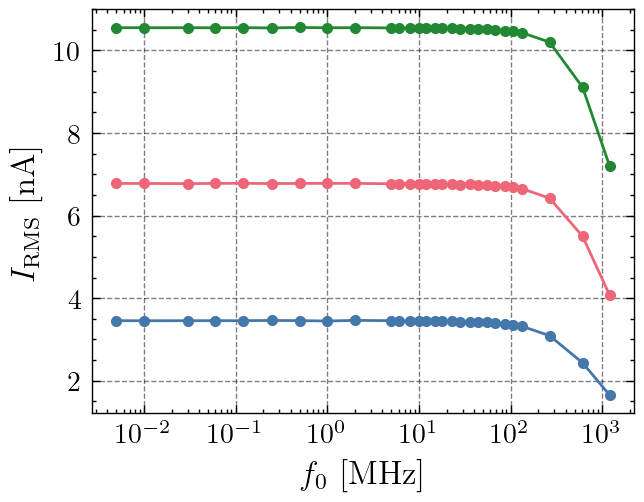

In [297]:
# Output RMS 
fig, ax = plt.subplots(dpi=200)
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, rms[i], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$I_{\\text{RMS}}$ [nA]", fontsize='large')

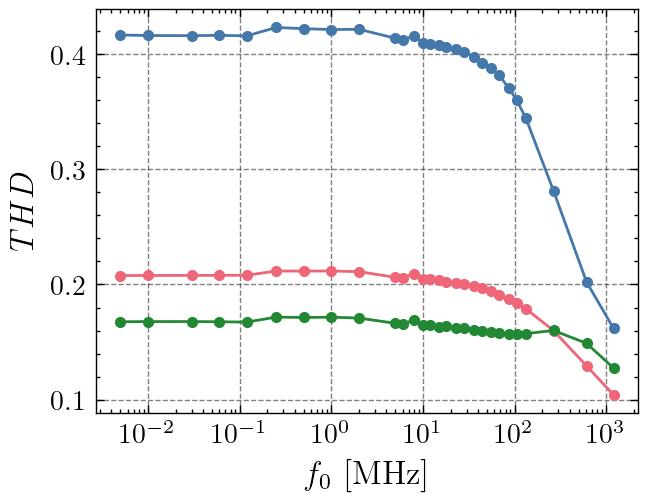

In [298]:
fig, ax = plt.subplots(dpi=200)
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, thd[i], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$THD$", fontsize='large')

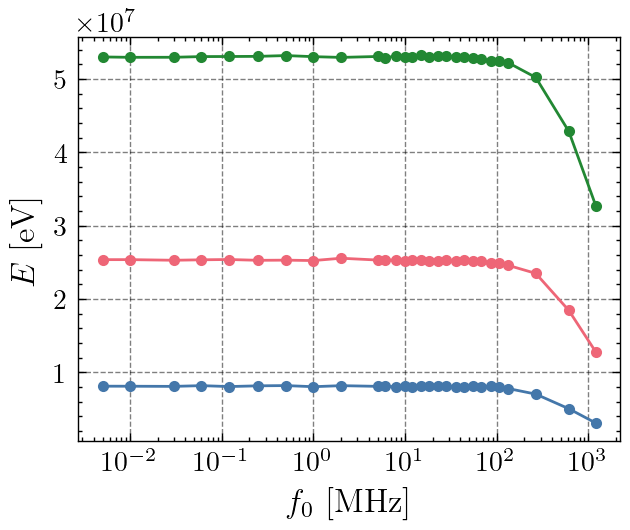

In [301]:
fig, ax = plt.subplots(dpi=200)
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, P_avg[i], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$E$ [eV]", fontsize='large')

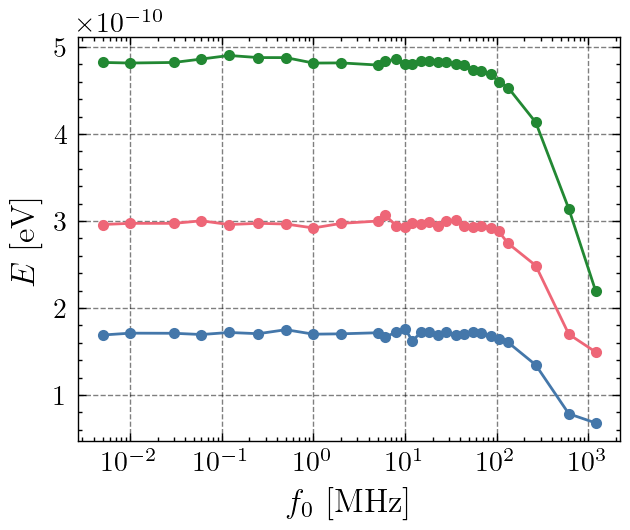

In [304]:
fig, ax = plt.subplots(dpi=200)
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, mem_window[i], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$E$ [eV]", fontsize='large')

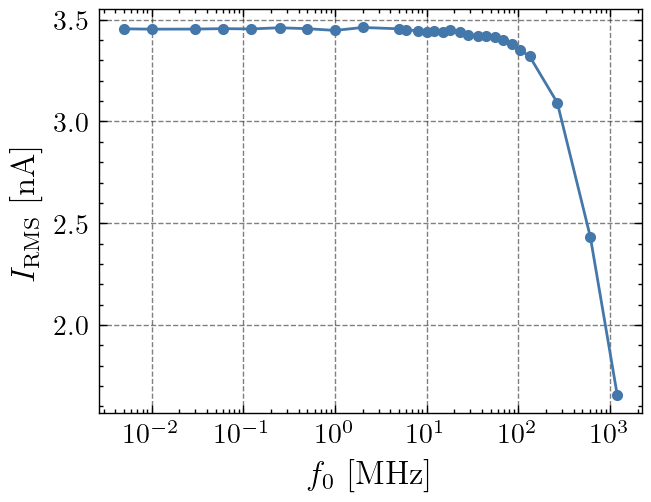

In [240]:
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, rms[0], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$I_{\\text{RMS}}$ [nA]", fontsize='large')

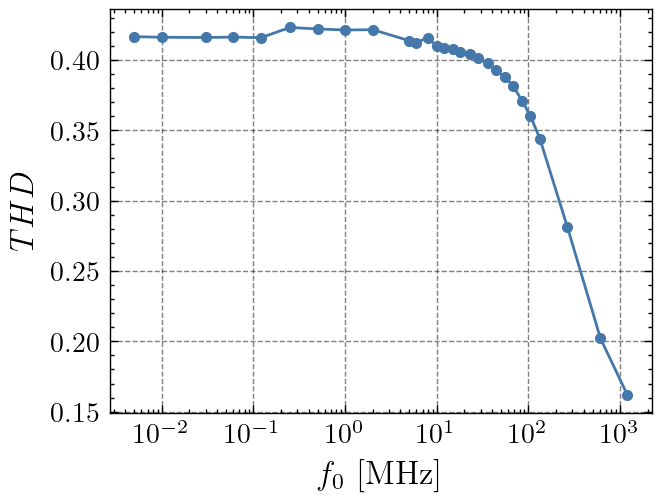

In [236]:
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, thd[0], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$THD$", fontsize='large')

In [309]:
FREQ_LIST_MHZ

[0.005,
 0.01,
 0.03,
 0.06,
 0.12,
 0.25,
 0.5,
 1.0,
 2.0,
 5.0,
 6.0,
 8.0,
 10.0,
 12.0,
 15.0,
 18.0,
 23.0,
 28.0,
 36.0,
 44.0,
 55.0,
 68.0,
 86.0,
 105.0,
 133.0,
 266.0,
 610.0,
 1200.0]

In [314]:
1e2

100.0

In [313]:
round(100e-9 / 1e-10)

1000

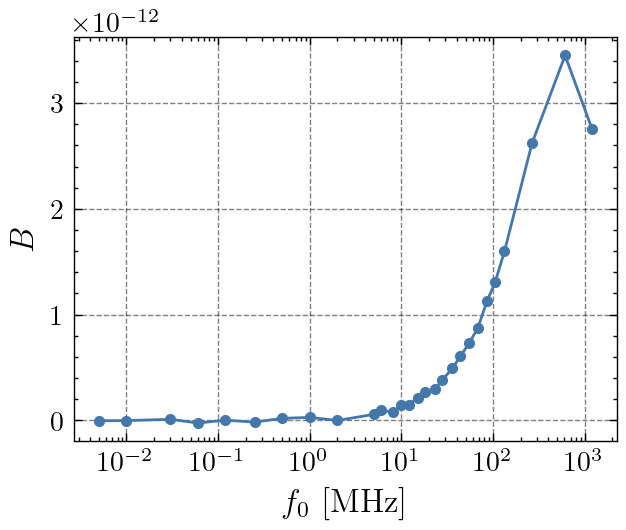

In [237]:
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, susceptance[0], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$B$", fontsize='large')

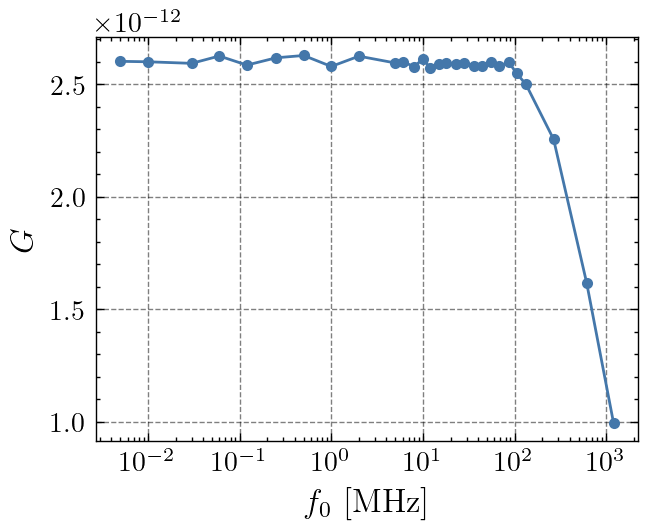

In [238]:
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, conductance[0], '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$G$", fontsize='large')

In [189]:
FREQ_LIST_MHZ

[0.005,
 0.01,
 0.03,
 0.06,
 0.12,
 0.25,
 0.5,
 1.0,
 2.0,
 5.0,
 6.0,
 8.0,
 10.0,
 12.0,
 15.0,
 18.0,
 23.0,
 28.0,
 36.0,
 44.0,
 55.0,
 68.0,
 86.0,
 105.0,
 133.0,
 266.0,
 610.0,
 1200.0,
 2400.0]

(0.0, 2.0833333333333334e-09)

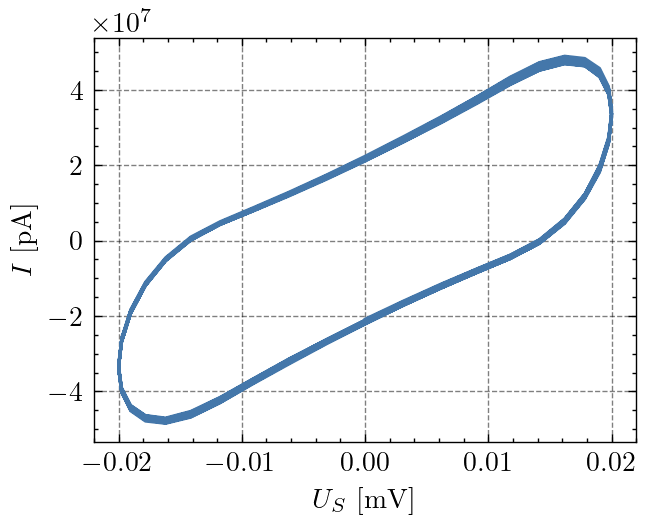

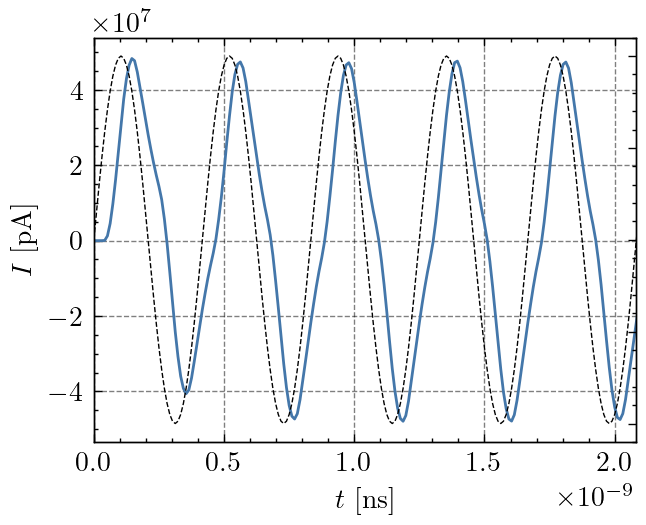

In [191]:
amp     = 0.02
freq    = 2400.0
fig, ax = plt.subplots(dpi=200)
ax.plot(x_vals[amp][freq][N_SKIP*SAMPLE_P_PERIOD:], y_vals[amp][freq][N_SKIP*SAMPLE_P_PERIOD:])
ax.set_xlabel("$U_S$ [mV]")
ax.set_ylabel("$I$ [pA]")

fig, ax = plt.subplots(dpi=200)
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_yticklabels("")
ax2.plot(t_vals[freq][:-1], x_vals[amp][freq], color='black', ls='--', lw=0.5)
ax.plot(t_vals[freq][:-1], y_vals[amp][freq])
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$I$ [pA]")
ax.set_xlim(0,t_vals[freq][5*N_PERIODS])

NEUROMORPHIC DEVICE CHARACTERIZATION REPORT

--- Memory Metrics ---
Max Separation (Memory Window):  0.000000
  Location (input value):        0.038040
Enclosed Area:                   0.000000
Normalized Area:                 0.0130 (0-1 scale)

--- State Distinguishability ---
Conductance Range:               0.000000
Conductance Ratio (max/min):     21.86

--- Nonlinearity & Symmetry ---
Forward Sweep Nonlinearity:      0.2117
Backward Sweep Nonlinearity:     0.2191
Asymmetry Index:                 0.2052

--- Interpretation ---
✓ Good state distinguishability (ratio > 10)
⚠ Weak hysteresis - limited memory retention
✓ Good symmetry (suitable for gradient-based learning)


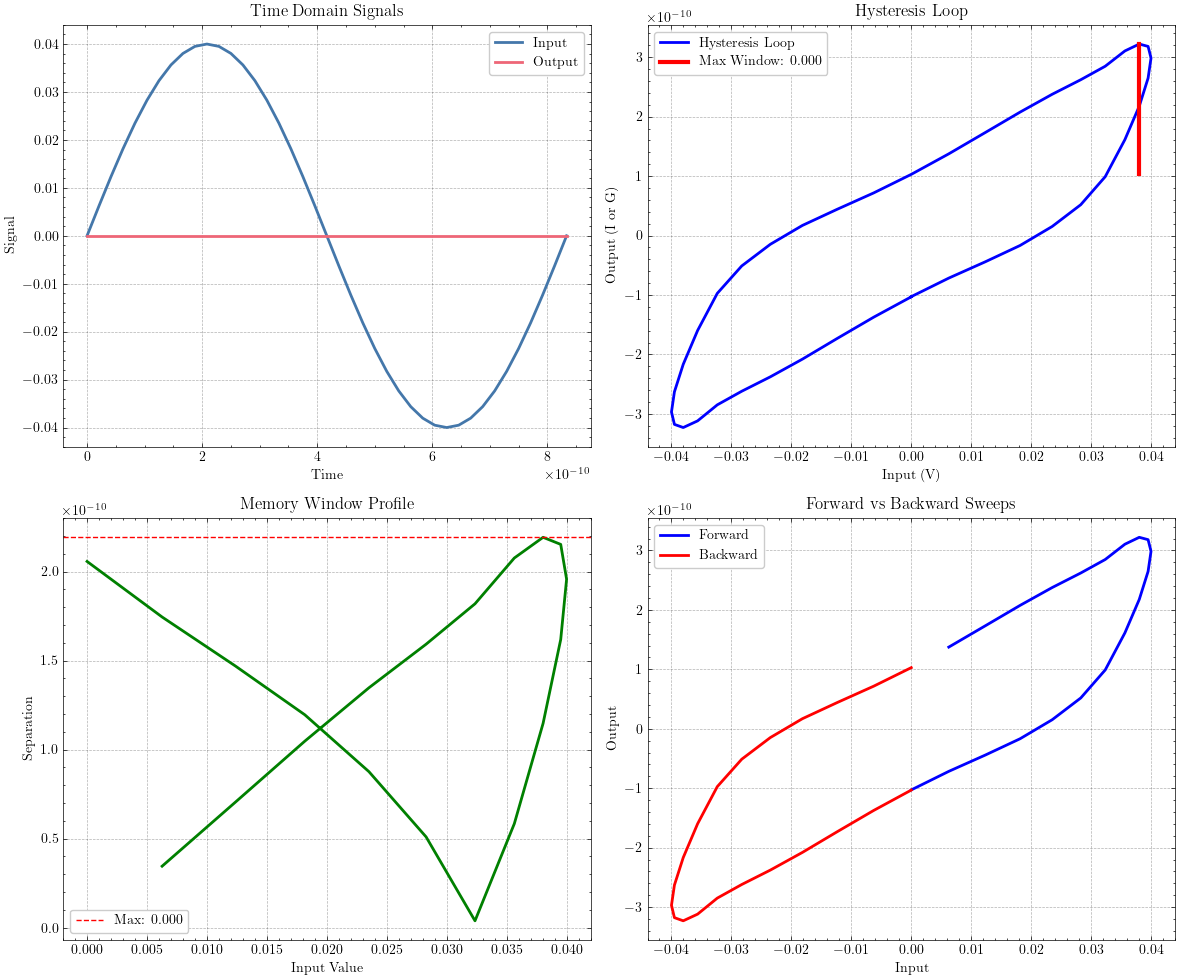

In [ ]:
import numpy as np
from scipy import integrate

def characterize_neuromorphic_device(input_signal, output_signal):
    """
    Comprehensive characterization of a memristive device for neuromorphic computing.
    
    Parameters:
    -----------
    input_signal : numpy array (1D)
        Input signal (e.g., voltage), typically a sine wave for one full cycle
    output_signal : numpy array (1D)
        Output signal (e.g., current or conductance) showing nonlinear/memristive response
    
    Returns:
    --------
    metrics : dict
        Dictionary containing various characterization metrics:
        - max_separation: Maximum vertical distance between forward/backward sweeps
        - separation_location: Input value where max separation occurs
        - enclosed_area: Total area enclosed by hysteresis loop
        - normalized_area: Area normalized by bounding box area
        - conductance_range: Difference between max and min output values
        - conductance_ratio: Ratio of max to min output (for resistance: HRS/LRS)
        - forward_nonlinearity: Measure of deviation from linearity (forward sweep)
        - backward_nonlinearity: Measure of deviation from linearity (backward sweep)
        - asymmetry_index: Measure of asymmetry between sweeps
    """
    
    metrics = {}
    
    # Split into forward and backward sweeps
    mid_idx = len(input_signal) // 2
    forward_input = input_signal[:mid_idx]
    forward_output = output_signal[:mid_idx]
    backward_input = input_signal[mid_idx:]
    backward_output = output_signal[mid_idx:]
    
    # === 1. Maximum Separation (Memory Window) ===
    backward_output_interp = np.interp(forward_input, 
                                        backward_input[::-1], 
                                        backward_output[::-1])
    separation = np.abs(forward_output - backward_output_interp)
    metrics['max_separation'] = np.max(separation)
    max_idx = np.argmax(separation)
    metrics['separation_location'] = forward_input[max_idx]
    
    # === 2. Enclosed Area (Hysteresis Strength) ===
    # Use shoelace formula for polygon area
    # Close the loop by ensuring start and end connect
    loop_x = np.concatenate([forward_input, backward_input[::-1]])
    loop_y = np.concatenate([forward_output, backward_output[::-1]])
    
    # Shoelace formula
    area = 0.5 * np.abs(np.sum(loop_x[:-1] * loop_y[1:] - loop_x[1:] * loop_y[:-1]) +
                        loop_x[-1] * loop_y[0] - loop_x[0] * loop_y[-1])
    metrics['enclosed_area'] = area
    
    # Normalized area (relative to bounding box)
    input_range = np.max(input_signal) - np.min(input_signal)
    output_range = np.max(output_signal) - np.min(output_signal)
    bounding_box_area = input_range * output_range
    metrics['normalized_area'] = area / bounding_box_area if bounding_box_area > 0 else 0
    
    # === 3. Conductance/Resistance Range ===
    metrics['conductance_range'] = np.max(output_signal) - np.min(output_signal)
    
    # Conductance ratio (or resistance ratio if dealing with resistance)
    min_val = np.min(np.abs(output_signal))
    max_val = np.max(np.abs(output_signal))
    if min_val > 0:
        metrics['conductance_ratio'] = max_val / min_val
    else:
        metrics['conductance_ratio'] = np.inf
    
    # === 4. Nonlinearity Measures ===
    # Measure deviation from best-fit line for each sweep
    def calculate_nonlinearity(x, y):
        # Fit linear model
        coeffs = np.polyfit(x, y, 1)
        y_linear = np.polyval(coeffs, x)
        # Calculate RMSE normalized by range
        rmse = np.sqrt(np.mean((y - y_linear)**2))
        y_range = np.max(y) - np.min(y)
        return rmse / y_range if y_range > 0 else 0
    
    metrics['forward_nonlinearity'] = calculate_nonlinearity(forward_input, forward_output)
    metrics['backward_nonlinearity'] = calculate_nonlinearity(backward_input, backward_output)
    
    # === 5. Asymmetry Index ===
    # Compare forward and backward sweep shapes
    mean_separation = np.mean(separation)
    metrics['asymmetry_index'] = mean_separation / metrics['conductance_range'] if metrics['conductance_range'] > 0 else 0
    
    return metrics


def print_device_report(metrics):
    """
    Print a formatted report of device characterization metrics.
    """
    print("=" * 60)
    print("NEUROMORPHIC DEVICE CHARACTERIZATION REPORT")
    print("=" * 60)
    
    print("\n--- Memory Metrics ---")
    print(f"Max Separation (Memory Window):  {metrics['max_separation']:.6f}")
    print(f"  Location (input value):        {metrics['separation_location']:.6f}")
    print(f"Enclosed Area:                   {metrics['enclosed_area']:.6f}")
    print(f"Normalized Area:                 {metrics['normalized_area']:.4f} (0-1 scale)")
    
    print("\n--- State Distinguishability ---")
    print(f"Conductance Range:               {metrics['conductance_range']:.6f}")
    print(f"Conductance Ratio (max/min):     {metrics['conductance_ratio']:.2f}")
    
    print("\n--- Nonlinearity & Symmetry ---")
    print(f"Forward Sweep Nonlinearity:      {metrics['forward_nonlinearity']:.4f}")
    print(f"Backward Sweep Nonlinearity:     {metrics['backward_nonlinearity']:.4f}")
    print(f"Asymmetry Index:                 {metrics['asymmetry_index']:.4f}")
    
    print("\n--- Interpretation ---")
    if metrics['conductance_ratio'] > 10:
        print("✓ Good state distinguishability (ratio > 10)")
    else:
        print("⚠ Limited state distinguishability (ratio < 10)")
    
    if metrics['normalized_area'] > 0.1:
        print("✓ Strong hysteresis/memory effect")
    else:
        print("⚠ Weak hysteresis - limited memory retention")
    
    if metrics['asymmetry_index'] < 0.3:
        print("✓ Good symmetry (suitable for gradient-based learning)")
    else:
        print("⚠ High asymmetry (may need compensation in learning algorithms)")
    
    print("=" * 60)


# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    # Generate example memristive device data
    v_input = x.copy()
    i_output = y.copy()
    
    # Characterize the device
    metrics = characterize_neuromorphic_device(v_input, i_output)
    
    # Print comprehensive report
    print_device_report(metrics)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Time domain
    ax1 = axes[0, 0]
    ax1.plot(t, v_input, label='Input', linewidth=2)
    ax1.plot(t, i_output, label='Output', linewidth=2)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Signal')
    ax1.legend()
    ax1.set_title('Time Domain Signals')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Hysteresis loop with memory window
    ax2 = axes[0, 1]
    ax2.plot(v_input, i_output, 'b-', linewidth=2, label='Hysteresis Loop')
    
    # Mark maximum separation
    mid_idx = len(v_input) // 2
    forward_input = v_input[:mid_idx]
    forward_output = i_output[:mid_idx]
    backward_input = v_input[mid_idx:]
    backward_output = i_output[mid_idx:]
    backward_output_interp = np.interp(forward_input, 
                                        backward_input[::-1], 
                                        backward_output[::-1])
    separation = np.abs(forward_output - backward_output_interp)
    max_idx = np.argmax(separation)
    
    ax2.plot([forward_input[max_idx], forward_input[max_idx]], 
             [forward_output[max_idx], backward_output_interp[max_idx]], 
             'r-', linewidth=3, label=f'Max Window: {metrics["max_separation"]:.3f}')
    ax2.set_xlabel('Input (V)')
    ax2.set_ylabel('Output (I or G)')
    ax2.set_title('Hysteresis Loop')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Separation profile
    ax3 = axes[1, 0]
    ax3.plot(forward_input, separation, 'g-', linewidth=2)
    ax3.axhline(y=metrics['max_separation'], color='r', linestyle='--', 
                label=f'Max: {metrics["max_separation"]:.3f}')
    ax3.set_xlabel('Input Value')
    ax3.set_ylabel('Separation')
    ax3.set_title('Memory Window Profile')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Forward vs Backward
    ax4 = axes[1, 1]
    ax4.plot(forward_input, forward_output, 'b-', linewidth=2, label='Forward')
    ax4.plot(backward_input, backward_output, 'r-', linewidth=2, label='Backward')
    ax4.set_xlabel('Input')
    ax4.set_ylabel('Output')
    ax4.set_title('Forward vs Backward Sweeps')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [308]:
metrics

{'max_separation': np.float64(2.192337848355091e-10),
 'separation_location': np.float64(0.03804),
 'enclosed_area': np.float64(6.729617086976722e-13),
 'normalized_area': np.float64(0.013039727865242833),
 'conductance_range': np.float64(6.451071253674702e-10),
 'conductance_ratio': np.float64(21.862469303728226),
 'forward_nonlinearity': np.float64(0.21174142507859833),
 'backward_nonlinearity': np.float64(0.21913762643558732),
 'asymmetry_index': np.float64(0.20521554767523553)}